In [22]:
import torch 
import torch.nn as nn
import numpy as np

In [2]:
data_dir = 'flower_data'
train_valid = ['train', 'valid']

In [15]:
from torchvision import datasets, transforms, models
import json
import os

In [4]:
# mean (sequence): Sequence of means for each channel.
# std (sequence): Sequence of standard deviations for each channel.
data_transforms = {'train': transforms.Compose([transforms.RandomRotation(45), transforms.CenterCrop(224),
                                                transforms.RandomHorizontalFlip(p = 0.5),
                                                transforms.RandomVerticalFlip(p = 0.5),
                                                transforms.ColorJitter(brightness = 0.2, contrast = 0.1, saturation = 0.1, hue = 0.1),
                                                transforms.RandomGrayscale(p = 0.025),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                                     std = [0.229, 0.224, 0.225])]),
                  'valid': transforms.Compose([transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                                  std = [0.229, 0.224, 0.225])])}

In [5]:
# Parameters
batch_size = 8

In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform = data_transforms[x]) for x in train_valid}
image_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle = True) for x in train_valid}
class_names = image_datasets['train'].classes

In [7]:
# Read real name of picture
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [8]:
# show image
def im_convert(tensor):
    #tensor.detach() creates a tensor that shares storage with tensor that does not require grad. 
    #tensor.clone() creates a copy of tensor that imitates the original tensor's requires_grad field.
    image = tensor.to('cpu').clone().detach()
    # Remove single-dimensional entries from the shape of an array.
    image = image.numpy().squeeze()
    #operands could not be broadcast together with shapes (3,224,224) (3,) 
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.0485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    return image

In [9]:
import matplotlib.pyplot as plt

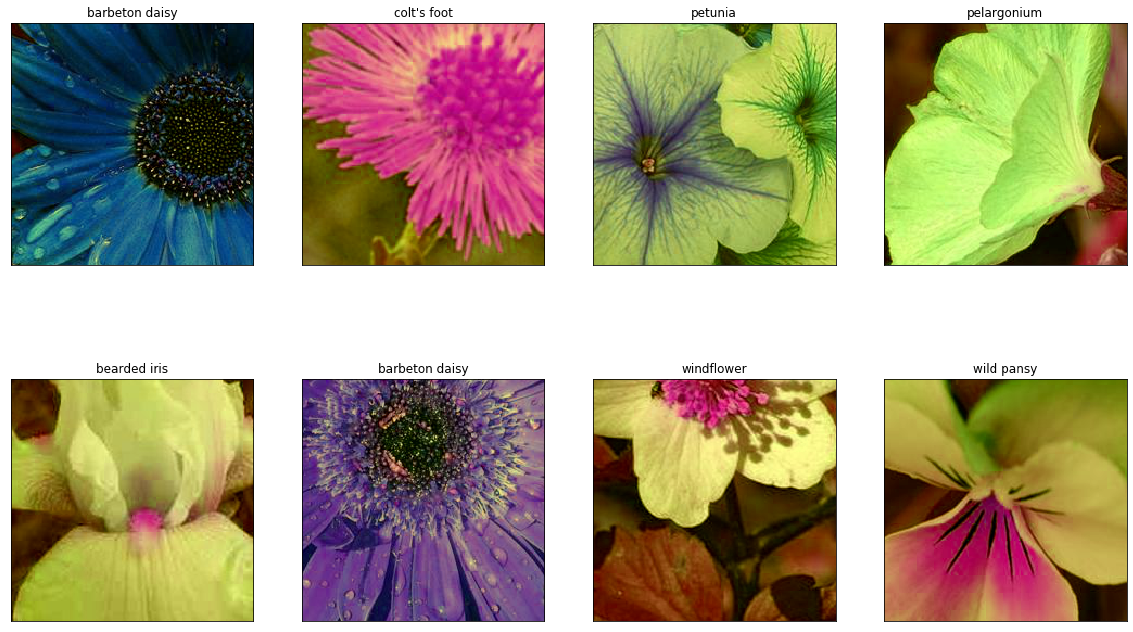

In [11]:
fig = plt.figure(figsize = (20, 12))
columns = 4
rows = 2

# generate one batch
dataiter = iter(image_loader['valid'])
inputs, classes = dataiter.next()

for idx in range(columns * rows):
    ax = fig.add_subplot(rows, columns, idx + 1, xticks = [], yticks = [])
    ax.set_title(cat_to_name[str(int(class_names[classes[idx]]))])
    plt.imshow(im_convert(inputs[idx])[:,:,[1,2,0]])
plt.show()

In [12]:
model_name = 'resnet'
feature_extract = True

In [48]:
def set_parameters_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            # Freeze some layers so that they won't be upgraded
            param.requires_grad = False

In [49]:
model_ft = models.resnet152()
model_ft.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [50]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained = True):
    model_ft = None
    input_size = 0
    
    # resnet152
    if model_name == 'resnet':
        model_ft = models.resnet152(pretrained = use_pretrained)
        set_parameters_requires_grad(model_ft, feature_extract)
        # in_features = 2048, out_features = 1000
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 102),
                                             nn.LogSoftmax(dim = 1))
        input_size = 224
        
    return model_ft, input_size

In [51]:
import urllib.request
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [52]:
model_ft, input_size = initialize_model('resnet', num_classes = 102, feature_extract = feature_extract
                                        , use_pretrained = True)

In [53]:
filename = 'resnet_checkpoint.pth'

# Whether to train all the layers
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print(name)

fc.0.weight
fc.0.bias


In [57]:
# Optimizer
optimizer_ft = torch.optim.Adam(params = params_to_update, lr = 1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer = optimizer_ft, step_size = 7, gamma = 0.1)
criterion = nn.NLLLoss()

In [59]:
import copy

In [61]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs = 25, in_inception = False, filename = filename):
    val_acc_history = []
    train_acc_histroy = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        for phase in ['train', 'valid']:
            # Change model state for train or valid
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            # Read dataloaders
            for inputs, labels in dataloaders[phase]:
                inputs = inputs
                labels = labels
                
                optimizer.zero_grad()
                # if phase == train, set grad enabled
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                
                    _, preds = torch.max(outputs, 1)
                
                    # if phase == train, upgrade weights
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            # Get best model
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                    'state_dict': model.state_dict(),
                    'best_acc': best_acc,
                    'optimizer': optimizer.state_dict(),
                }
                
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
                
        
    print('Best Acc: {.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs
                

In [63]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs = train_model(model_ft, image_loader,
                                                                                           criterion, optimizer_ft,
                                                                                           num_epochs = 20)

Epoch 0/19
----------


KeyboardInterrupt: 